In [1]:
import sys
import os
sys.path.append(f'{os.path.dirname(os.getcwd())}/utils')
from data_util import (download_data_local_check, prep_stock_data, prep_fx_data, calc_sharpe)

In [2]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import (train_test_split,  
                                     KFold, 
                                     cross_val_score,
                                     cross_val_predict,
                                    )
from datetime import datetime, timedelta, time
import plotly.graph_objects as go
import sklearn.metrics as metrics
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import scikitplot as skplt
import xgboost as xgb
import pandas as pd
import numpy as np
import requests
import asyncio 
import aiohttp  # pip install aiohttp aiodns 
import pickle
import talib
import time
import json
import os

C:\Users\Jameshuckle\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
%matplotlib inline 
pd.options.display.max_rows= 1000
pd.options.display.max_columns= 1000

import predict_crypto_prices as pcp

In [4]:
data_source = 'stock' # 'fx', 'stock'

if data_source == 'fx':
    ### FX data #######
    fx_files = [
                 'EURUSD_1h_2003-2020.csv',
                 'GBPUSD_1h_2003-2020.csv',
                 'USDJPY_1h_2003-2020.csv',
                 'NZDUSD_1h_2003-2020.csv',
                 'AUDUSD_1h_2003-2020.csv',
                 'USDCAD_1h_2003-2020.csv',
                 'USDCHF_1h_2003-2020.csv',
                 ]

    loaded_files = prep_fx_data(fx_files)
        
if data_source == 'stock':
    ### stock data ######
    start = '2000-01-01'
    end = '2020-11-1'
    ## download data
    all_stock_data = download_data_local_check('SP500', start, end)
    loaded_files = prep_stock_data(all_stock_data, filter_start_date_tuple=None,
                                   volume=True) #(2015,1,1)

data already saved C:\Users\Jameshuckle\Dropbox\My-Portfolio\AlgorithmicTrading/data/SP500_all_stock_data_2000-01-01-2020-11-1.csv
num stocks: 505
EXPE has moves that are too large
MO has moves that are too large
HIG has moves that are too large
OXY has moves that are too large
AAPL has moves that are too large
ROK has moves that are too large
KSU has moves that are too large
JCI has moves that are too large
WMB has moves that are too large
BRK.B does not have enough data
AIG has moves that are too large
WY has moves that are too large
UA has moves that are too large
PWR has moves that are too large
BF.B does not have enough data
REGN has moves that are too large
APA has moves that are too large
STT has moves that are too large
VNT does not have enough data


In [5]:
def normalize_bars(data, col, norm_ma=1000):
    mins = data[col].rolling(window=norm_ma, min_periods=100).min()
    maxs = data[col].rolling(window=norm_ma, min_periods=100).max()
    means = data[col].rolling(window=norm_ma, min_periods=100).mean()
    ranges = maxs - mins
    #data[col] = (data[col] - mins) / ranges
    data[col] = (data[col] - means) / ranges
    data[col].replace([np.inf, -np.inf], 0, inplace=True)
    return data


def rolling_bar_volatility(data, ma=100):
    bar_high_low = data['high'] - data['low']
    bar_high_low_pct_diff = bar_high_low / data['high']
    roll_avg_bar_pct_size = (bar_high_low_pct_diff.rolling(window=ma, min_periods=0).mean()
                            .reset_index(drop=True))
    roll_avg_bar_pct_size = np.array(roll_avg_bar_pct_size)
    return roll_avg_bar_pct_size


def triple_barrier(data, window=1, bar_horizon=1000, bar_size_ma=100, target_stop_size=3,
                   target_stop_type='high_low', problem_type='binary', just_labels=False):

    last_bars = data['close'].shift(-(window - 1))
    roll_avg_bar_pct_size = rolling_bar_volatility(data, ma=bar_size_ma)
    child_pct = roll_avg_bar_pct_size * target_stop_size
    child_distance = last_bars * child_pct
    target_series = last_bars + child_distance
    stop_series = last_bars - child_distance

    if target_stop_type == 'high_low':
        highs = data['high'].to_numpy()
        lows = data['low'].to_numpy()
        opens = data['open'].to_numpy()
    elif target_stop_type == 'close':
        highs = lows = data['close'].to_numpy()
        opens = data['open'].to_numpy()
    else:
        raise Exception('target_stop_type not recognised!')
        
    closes = data['close'].to_numpy()
    targets = target_series.to_list()
    stops = stop_series.to_list()

    not_hit_target_or_stop = 0
    hit_target_and_stop = 0
    gap_stop = 0
    gap_target = 0
    labels = []
    for idx in range(len(closes)):
        if idx == (len(closes) - window):
            labels.append([np.nan, closes[-1], 'neither'])
            break

        last_bar = last_bars[idx]
        target = targets[idx]
        stop = stops[idx]
        start_idx = (window - 1) + idx + 1
        future_highs = highs[start_idx: start_idx + bar_horizon]
        future_lows = lows[start_idx: start_idx + bar_horizon]
        future_closes = closes[start_idx: start_idx + bar_horizon]
        future_opens = opens[start_idx: start_idx + bar_horizon]
        
        larger_than_target = future_highs > target
        target_idx = None if larger_than_target.sum() == 0 else larger_than_target.argmax()
        smaller_than_stop = future_lows < stop
        stop_idx = None if smaller_than_stop.sum() == 0 else smaller_than_stop.argmax()

        if target_idx == None and stop_idx == None:
            # manual exit at end of bar horizon
            not_hit_target_or_stop += 1
            fraction_target_stop = (future_closes[-1] - last_bar) / child_distance[idx]
            labels.append([fraction_target_stop, future_closes[-1], 'neither'])
        elif target_idx == None:
            labels.append([-1, stop, 'stop'])
        elif stop_idx == None:
            labels.append([1, target, 'target'])
        elif stop_idx < target_idx:
            if future_opens[stop_idx] < stop:
                gap_stop += 1
                fraction_target_stop = (future_opens[stop_idx] - last_bar) / child_distance[idx]
                labels.append([fraction_target_stop, future_opens[stop_idx], 'target'])
            else:
                labels.append([-1, stop, 'stop'])
        elif target_idx < stop_idx:
            if future_opens[target_idx] > target:
                gap_target += 1
                fraction_target_stop = (future_opens[target_idx] - last_bar) / child_distance[idx]
                labels.append([fraction_target_stop, future_opens[stop_idx], 'stop'])
            else:
                labels.append([1, target, 'target'])
        elif target_idx == stop_idx:
            hit_target_and_stop += 1
            random_side =  np.random.choice([0,1])
            if random_side == 0:
                labels.append([-1, stop, 'rand_stop'])
            else:
                labels.append([1, target, 'rand_target'])
        else:
            raise Exception('stop or target not recognised, bug!')
       
    print(f'# trades not hit target or stop: {not_hit_target_or_stop}')
    print(f'# trades hit both target and stop: {hit_target_and_stop}')
    print(f'# trades gapped stop: {gap_stop} | # trades gapped target: {gap_target}')
    
    for _ in range(window - 1):
        labels.append([np.nan, closes[-1], 'end of data'])
        
    target_stops = pd.DataFrame(labels, columns=['perc_target_stop',
                                                 'price_target_stop',
                                                 'target_stop_class'])
    target_stops.index = data.index
    data['perc_target_stop'] = target_stops['perc_target_stop']
    if not just_labels:
        data['last_bar'] = last_bars
        data['child_pct'] = child_pct
        data['child_dist'] = child_distance
        data['target_level'] = target_series
        data['stop_level'] = stop_series
        data['price_target_stop'] = target_stops['price_target_stop']
        data['target_stop_class'] = target_stops['target_stop_class']
        
    if problem_type == 'binary':
        data['target'] = (target_stops['perc_target_stop'] >= 0).astype(int) 
        print('dropping trades that did not meet a target or stop!')
        #data = data[target_stops['target_stop_class'].isin(['stop', 'target'])]
    elif problem_type == 'category':
        data = data[target_stops['target_stop_class'].isin(['stop', 'target', 'neither'])]
        hit_target = target_stops['target_stop_class'] == 'target'
        hit_stop = target_stops['target_stop_class'] == 'stop'
        hit_neither = target_stops['target_stop_class'] == 'neither'
        data.loc[hit_target, 'target'] = 2
        data.loc[hit_stop, 'target'] = 0
        data.loc[hit_neither, 'target'] = 1
    return data


def plot_target_stop(data, var, bars, start_idx, v_line_delta, h_line_price):
    # only plots HOURLY price data currently
    cols = ['open', 'high', 'low', 'close']
    plot_frame = data[cols + ['stop_level', 'target_level', 'perc_target_stop']].copy()
    for col in var.cols:
        plot_frame[f'last_{col}'] = plot_frame[col].shift(-(var.window - 1))
    
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,6), gridspec_kw={'height_ratios': [3, 1]})
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plot_cols = [f'last_{col}' for col in cols]
    plot_frame[plot_cols + ['stop_level', 'target_level']][start_idx:start_idx+bars].plot(
        ax=ax[0], style=['g','grey','grey','r','k--','k--'])
    v_line_idx = plot_frame[start_idx:start_idx+bars].index[0] + v_line_delta
    ax[0].axvline(v_line_idx, c='k', linewidth=1)
    ax[0].axhline(h_line_price, c='k', linewidth=1)
    
    data['perc_target_stop'][start_idx:start_idx+bars].plot(ax=ax[1])
    ax[1].axvline(v_line_idx, c='k', linewidth=1)
    plt.show()
    return plot_frame[start_idx:start_idx+bars]

In [6]:
resample = '1D' # None , '1D'
num_instruments = 10

all_files = []
for i, (file, data) in enumerate(loaded_files.items()):
    print(i, file)   
    if i >= num_instruments:
        opps = [x for x in loaded_files.keys() if 'opp-' in x][:num_instruments]
        if file not in opps:
            continue
    if len(data) < (100):
        print(f'{file} not enough data')
        continue
        
    data = data.copy()
    data.columns = data.columns.str.lower()
    if resample:
        data = data.resample(resample).agg({'open':'first','high':'max',
                                            'low':'min','close':'last', 'volume':'sum'})
    data = data.ffill()
    data.reset_index(inplace=True)
    data.rename({'Gmt time': 'time'}, axis='columns', inplace=True)
    data['daily_return'] = data['close'].pct_change()
    data = triple_barrier(data, window=1, bar_horizon=1000, bar_size_ma=200, target_stop_size=2,
                          target_stop_type='high_low', problem_type='binary', just_labels=True)
    data.rename({'target_stop_label': 'target'}, axis='columns', inplace=True)
    data = pcp.feature_pipeline(data, volume_col='volume')
    data.set_index('time', inplace=True)
    data.ffill(inplace=True)
    data.dropna(inplace=True)
    
    keep_cols = ['open', 'high', 'low', 'close', 'daily_return']
    norm_cols = [f'norm_{c}' for c in keep_cols]
    data[norm_cols] = data[keep_cols]
    not_features = ['open', 'high', 'low', 'close', 'daily_return', 'target', 'perc_target_stop']
    features = [c for c in list(data.columns) if c not in not_features]
    for col in features:
        if len(sorted(list(data[col].value_counts().keys()))) <= 3:
            continue
        elif col in ['time'] + keep_cols:
            continue
        else:
            data = normalize_bars(data, col, norm_ma=10000)
            
    data.dropna(inplace=True)
    all_files.append(data)
    
all_data = pd.concat(all_files).sort_values('time')

0 FDX
# trades not hit target or stop: 2
# trades hit both target and stop: 9
# trades gapped stop: 499 | # trades gapped target: 329
dropping trades that did not meet a target or stop!
roll 1 done
roll 2 done
roll 3 done
high_low done
ema done
stoch_turn done
candlestick_patters done
adx done
rsi done
all done
1 PNC
# trades not hit target or stop: 36
# trades hit both target and stop: 15
# trades gapped stop: 409 | # trades gapped target: 401
dropping trades that did not meet a target or stop!
roll 1 done
roll 2 done
roll 3 done
high_low done
ema done
stoch_turn done
candlestick_patters done
adx done
rsi done
all done
2 NTAP
# trades not hit target or stop: 3
# trades hit both target and stop: 0
# trades gapped stop: 576 | # trades gapped target: 394
dropping trades that did not meet a target or stop!
roll 1 done
roll 2 done
roll 3 done
high_low done
ema done
stoch_turn done
candlestick_patters done
adx done
rsi done
all done
3 ORLY
# trades not hit target or stop: 16
# trades hit bo

In [7]:
# data_path = f'{os.path.dirname(os.getcwd())}/data'
# all_data.to_csv(f'{data_path}/fx_xgboost_data_{resample}.csv')
# all_data = pd.read_csv(f'{data_path}/fx_xgboost_data_{resample}.csv', index_col='time')
# all_data.index = pd.to_datetime(all_data.index)

In [8]:
## load dnn data
# data_path = f'{os.path.dirname(os.getcwd())}/data'
# all_data = pd.read_csv(f'{data_path}/fx_dnn_data_None.csv', index_col='Gmt time')
# all_data.index = pd.to_datetime(all_data.index)
# all_data.rename({'target':'target_placement',
#                  'target_stop_label': 'target'}, axis='columns', inplace=True)

In [9]:
binary_perc = all_data['target'].value_counts(normalize=True).values
print('binary class proportions', binary_perc)
data = all_data

binary class proportions [0.54818653 0.45181347]


In [10]:
def target_stop_ratio(data, name='train'):
    t_s_ratio = data['target'].value_counts().to_dict()
    t_s_perc = data['target'].value_counts(normalize=True).to_dict()[1]
    print(t_s_ratio)
    print(f'percentage that hit target at base ({name}): {t_s_perc:.3f}')
    return t_s_perc

def training_split(data, train_split_list, features, label):
    # data must have datetime index

    # train/valid/test split
    input_data = {}
    input_data['train'] = data[data.index < train_split_list[0]]
    input_data['test'] = data[data.index >= train_split_list[-1]]
    if len(train_split_list) == 2:
        input_data['valid'] = data[((data.index >= train_split_list[0]) & 
                                    (data.index < train_split_list[1]))]
        
    for key, d in input_data.items():
        print(key, d.shape)
        if len(d) == 0:
            raise Exception(f'no data in {key}')

    input_data['x_train'] = input_data['train'][features].to_numpy()
    input_data['y_train'] = input_data['train'][label].to_numpy().reshape(-1, 1)
    input_data['x_test'] = input_data['test'][features].to_numpy()
    input_data['y_test'] = input_data['test'][label].to_numpy().reshape(-1, 1)
    if len(train_split_list) == 2:
        input_data['x_valid'] = input_data['valid'][features].to_numpy()
        input_data['y_valid'] = input_data['valid'][label].to_numpy().reshape(-1, 1)
        
    t_s_perc = target_stop_ratio(input_data['train'], 'train')
    if len(train_split_list) == 2:
        t_s_perc = target_stop_ratio(input_data['valid'], 'valid')
    t_s_perc = target_stop_ratio(input_data['test'], 'test')
    
    return input_data
  
# train_split = [datetime(2019, 1, 1)]
# label = 'target'
# features = [str(c) for c in list(range(400))]
# input_data = training_split(data, train_split, features, label)
 
features = [c for c in all_data if c not in ['target','perc_target_stop']]
train_split = [datetime(2018, 1, 1)]
label = 'target'
input_data = training_split(data, train_split, features, label)

train (57210, 1004)
test (10340, 1004)
{1: 31317, 0: 25893}
percentage that hit target at base (train): 0.547
{1: 5713, 0: 4627}
percentage that hit target at base (test): 0.553


In [25]:
model = xgb.XGBClassifier(objective='binary:logistic', verbosity=0,
                          max_depth=10,
                          min_child_weight=30,
                          gamma=10,
                         )

In [26]:
print('fitting model')
model.fit(input_data['x_train'], input_data['y_train'])

fitting model


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=10, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=30, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=0)

In [27]:
#model.save_model('model.json')
#model.load_model('model.json')

In [28]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(input_data['x_test'])
accuracy_score(input_data['y_test'], y_pred)

0.532688588007737

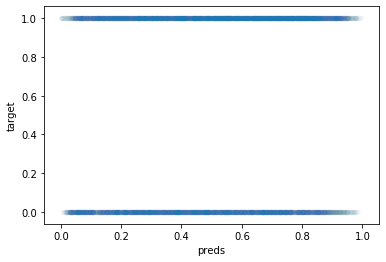

In [29]:
review_set = 'test' # 'test', 'train'

predictions = model.predict_proba(input_data[f'x_{review_set}'])[:,1]
# predictions = model.predict(input_data[f'x_{review_set}'])
# print(pd.Series(predictions).value_counts(normalize=True)[1])

input_data[review_set]['preds'] = predictions
test_results = input_data[review_set][['target','preds']].copy()
test_results['perc_target_stop'] = input_data[review_set]['perc_target_stop']

plot_preds = True
if plot_preds:
    # plot scatter of preds vs label
    test_results.plot.scatter(x='preds', y='target', alpha=0.01); plt.show()

-----
test
Accuracy (manual calc): 0.533
Sharpe: 1.23
-----
train
Accuracy (manual calc): 0.971
Sharpe: 47.82


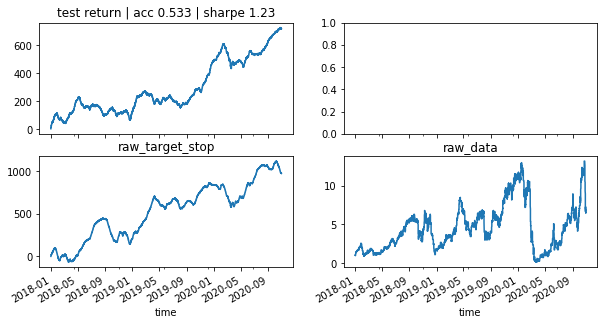

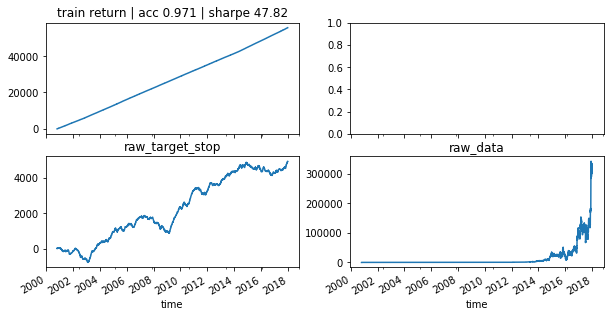

In [30]:
def calc_sharpe(returns, time_frame='1D', scale_returns=0.001):
    resample = False
    if time_frame in [None, False]:
        correction = np.sqrt(24*365)
    elif time_frame == '4H':
        correction = np.sqrt(6*365)        
    elif time_frame == '1D':
        correction = np.sqrt(365)
    elif time_frame == '1W':
        correction = np.sqrt(4)
    else:
        raise Exception(f'time_frame "{time_frame}" is not recognized!')
        
    col = returns.name
    returns = returns * scale_returns
    sharpe = (returns.mean() / returns.std()) * correction
    return sharpe


def calc_returns(test_results, review_set, label='target', close_diff_col='ohlc_diff_close', 
                 time_frame='1H'):
    fig, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
    if var.problem_type == 'binary':
        test_results['binary_pred'] = (test_results['preds'] >= 0.5).astype(int)
        test_results['trade_map'] = test_results['binary_pred'].replace(0, -1)
    elif var.problem_type == 'category':
        test_results['binary_pred'] = test_results['preds']
        test_results['trade_map'] = test_results['preds'] - 1
    test_results['return'] = test_results['perc_target_stop'] * test_results['trade_map']
    test_results['correct'] = ((test_results[label] == test_results['binary_pred']).astype(int))
    acc = test_results['correct'].mean()
    sharpe = calc_sharpe(test_results['return'], time_frame, scale_returns=0.01)
    print('-----')
    print(review_set)
    print(f"Accuracy (manual calc): {acc:.3f}")
    print(f"Sharpe: {sharpe:.2f}")
    
    # plot charts     
    test_results['return'].cumsum().plot(
        title=f'{review_set} return | acc {acc:.3f} | sharpe {sharpe:.2f}', ax=ax[0,0])
    (input_data[review_set][close_diff_col] + 1).cumprod().plot(title='raw_data', ax=ax[1,1])
    test_results['perc_target_stop'].cumsum().plot(title='raw_target_stop', ax=ax[1,0])
    returns_plot = plt.gca()      
    return returns_plot, test_results, sharpe
    
class variables():
    None
var = variables()
var.resample = '1D'
var.problem_type = 'binary'

for review_set in ['test', 'train']:
#for review_set in ['test']:
    predictions = model.predict_proba(input_data[f'x_{review_set}'])[:,1]
    input_data[review_set]['preds'] = predictions
    test_results = input_data[review_set][['target','preds']].copy()
    test_results['perc_target_stop'] = input_data[review_set]['perc_target_stop']
    returns_plot, test_results, sharpe = calc_returns(test_results, review_set, label='target',
                                                      close_diff_col='daily_return',
                                                      time_frame=var.resample)

In [31]:
def show_feature_importance(features, num):
    importances = dict(zip(features , model.feature_importances_))
    importances = pd.Series(importances)                                                                                                                                     
    importances = importances.sort_values(ascending=False)
    imp_features = importances.head(num)
    return imp_features

show_feature_importance(features, num=100)

ema_132_high                      0.008150
ema_162_close                     0.005777
ema_142_close_diff_close          0.005443
volume_pct_change_roll_mean_87    0.004738
extreme_low_55                    0.004723
ema_2_low                         0.004410
ema_122_close_diff_high           0.004380
ema_112_close_diff_low            0.004051
slowk_14_7                        0.004044
ema_52_high_diff_low              0.003837
ema_142_close                     0.003788
distance_from_high_low_40         0.003719
ema_172_close_diff_close          0.003582
dist_from_low_window_100          0.003557
ema_122_close_diff_close          0.003535
extreme_high_95                   0.003531
extreme_high_70                   0.003508
extreme_low_40                    0.003396
ema_72_low                        0.003336
ema_102_high_diff_low             0.003327
volume_pct_change_roll_max_77     0.003234
extreme_high_25                   0.003201
ema_162_low_diff_close            0.003200
ema_32_clos